## 시계열데이터 예측/분류 모델(lightGBM)

Step A. Features Engineering
Step B. lightGBM modeling
Step C. Features Reduction
Step D. Hyperparameter Optimization
Step E. Save the model

#### Step A. Feature Engineering

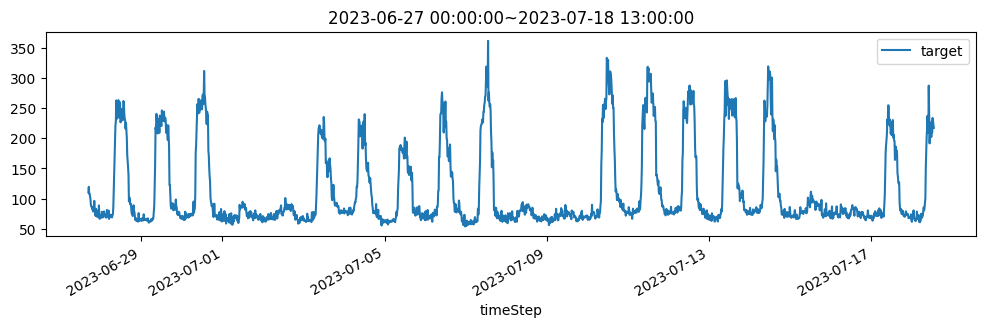

In [2]:
# lightGBM·을 이용한 시계열 예측 모듈
import numpy as np
import pandas as pd
import holidays
import lightgbm as lgb
#from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from pandas.tseries.offsets import CustomBusinessDay
import datetime
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

import Utility as Util

file_path = r"/home/ymatics/CodingSpace/2024_AI_BEMS/df_selected.pickle"
df_raw = pd.read_pickle(file_path)
#start_date, end_date = pd.to_datetime('2023-06-01 00:00:00'), pd.to_datetime('2023-07-19 00:00:00')
start_date, end_date = pd.to_datetime('2023-06-27 00:00:00'), pd.to_datetime('2023-07-18 13:00:00')
df = df_raw.loc[start_date:end_date].copy()
Util.plot_data(df=df, title=f"{start_date}~{end_date}", plotType='simple', W=12, H=3)

p_ = 4  # 15min, 4 points/hr
# 시간 기반 피쳐 생성 (대한민국의 주마 및 공휴일 반응)
kr_holidays = holidays.KR()
kr_business_day = CustomBusinessDay(holidays=kr_holidays)

df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)  # 주말 여부
df['is_holiday'] = df.index.isin(kr_holidays).astype(int)  # 공휴일 여부

# 연휴 전후 여부 특성 추가 (설날 및 추석 연휴 포함)
major_holiday_dates = pd.to_datetime([date for date in kr_holidays if kr_holidays[date] in ['설날', '추석']])
df.loc[df.index.isin(major_holiday_dates - pd.DateOffset(days=1)), 'is_holiday'] = 1
df.loc[df.index.isin(major_holiday_dates + pd.DateOffset(days=1)), 'is_holiday'] = 1

# kr_holidays를 datetime으로 변환
holiday_dates = pd.to_datetime(list(kr_holidays.keys()))
#df['is_before_holiday'] = df.index.shift(-1, freq='D').isin(holiday_dates).astype(int)  # 연휴 전날 여부
#df['is_after_holiday'] = df.index.shift(1, freq='D').isin(holiday_dates).astype(int)  # 연휴 다음 날 여부

# 특정 명절 및 중요 휴일 특성 추가
##major_holidays.append('어린이날')
##df['is_major_holiday'] = df.index.to_series().apply(lambda x: 1 if x in kr_holidays and kr_holidays[x] in major_holidays else 0)

# 대체공휴일 보정
for date in kr_holidays:
    if date.weekday() in [5, 6]:
        replacement_date = date + datetime.timedelta(days=1)
        while replacement_date.weekday() in [5, 6] or replacement_date in kr_holidays:
            replacement_date += datetime.timedelta(days=1)
        df.loc[replacement_date, 'is_holiday'] = 1

# 공휴일 전후 주중/주말 여부 추가
#df['is_holiday_weekend'] = ((df['is_holiday'] == 1) & df['is_weekend'] == 1).astype(int)  # 공휴일이 주말인 경우
#df['is_holiday_weekday'] = ((df['is_holiday'] == 1) & df['is_weekend'] == 0).astype(int)  # 공휴일이 주중인 경우
#df['is_month_end'] = df.index.is_month_end.astype(int)  # 월별 마지막 날 여부
#df['is_month_start'] = df.index.is_month_start.astype(int)  # 월초 여부

# 시간 지연 피쳐 생성
df['lag_1p'] = df['target'].shift(1)  # 1h delayed pattern
df['lag_2p'] = df['target'].shift(2)  
df['lag_3p'] = df['target'].shift(3)  
df['lag_4p'] = df['target'].shift(4)  
df['lag_1d_0p'] = df['target'].shift(p_ * 24 + 0)  # 1day = 4p_ x 24h/p_ delayed pattern
df['lag_1d_1p'] = df['target'].shift(p_ * 24 + 1)  
df['lag_1d_2p'] = df['target'].shift(p_ * 24 + 2)  
df['lag_1d_3p'] = df['target'].shift(p_ * 24 + 3)  
df['lag_1d_4p'] = df['target'].shift(p_ * 24 + 4)  
df['lag_1w_0p'] = df['target'].shift(p_ * 24 * 7 + 0)  # 1w = 4p_ x 24h/p_ x 7days delayed pattern
df['lag_1w_1p'] = df['target'].shift(p_ * 24 * 7 + 1)  
df['lag_1w_2p'] = df['target'].shift(p_ * 24 * 7 + 2)  
df['lag_1w_3p'] = df['target'].shift(p_ * 24 * 7 + 3)  
df['lag_1w_4p'] = df['target'].shift(p_ * 24 * 7 + 4) 

# 변동률 및 변동률의 변동률 피쳐 생성
epsilon = 1e-3
shifted = df['target'].shift(1)
divisor = np.where(np.abs(shifted) > epsilon, shifted, np.sign(shifted) * epsilon)
df['rate'] = (df['target'] - df['target'].shift(1)) / divisor
df['diff_rate'] = df['rate'] - df['rate'].shift(1)

shifted_1d = df['target'].shift(p_ * 24)  # 하루 전의 동일 시간대 변동률의 변동률
divisor_1d = np.where(np.abs(shifted_1d) > epsilon, shifted_1d, np.sign(shifted_1d) * epsilon)
df['rate_1d'] = (df['target'] - df['target'].shift(p_ * 24)) / divisor_1d
df['diff_rate_1d'] = df['rate_1d'] - df['rate_1d'].shift(1)

# 이동 평균 피처 생성
df['ma_1d'] = df['target'].rolling(window=p_ * 24).mean()  # 현재부터 1day 통계
df['max_1d'] = df['target'].rolling(window=p_ * 24).max()  
df['min_1d'] = df['target'].rolling(window=p_ * 24).min()  
df['std_1d'] = df['target'].rolling(window=p_ * 24).std() 

df['p1d_ma_1d'] = df['target'].shift(p_*24).rolling(window=p_ * 24).mean()  # 1일전 1day 통계
df['p1d_max_1d'] = df['target'].shift(p_*24).rolling(window=p_ * 24).max()  
df['p1d_min_1d'] = df['target'].shift(p_*24).rolling(window=p_ * 24).min()  
df['p1d_std_1d'] = df['target'].shift(p_*24).rolling(window=p_ * 24).std() 

df['p1w_ma_1d'] = df['target'].shift(p_*24*7).rolling(window=p_ * 24).mean()  # 1주일전 1day 통계
df['p1w_max_1d'] = df['target'].shift(p_*24*7).rolling(window=p_ * 24).max()  
df['p1w_min_1d'] = df['target'].shift(p_*24*7).rolling(window=p_ * 24).min()  
df['p1w_std_1d'] = df['target'].shift(p_*24*7).rolling(window=p_ * 24).std() 

# 추세 및 계절성 분포
df['trend'] = np.arange(len(df))
df['season'] = df['target'] - df['ma_1d']

# 계절성 피처 생성
df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

# 주기성 특성 (Cyclical Features)
df['sine_day'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
df['cosine_day'] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)

# 외부 변수 추가 (예: 기온 데이터)
#external_data = pd.read_csv('external_data.csv')
#df = df.merge(external_data, on='date', how='left')
#df['temperature'] = df['temperature']

# 결측값 처리 (특징 벡터 생성 후 생성된 NaN 처리)
df.bfill(inplace=True)
df.ffill(inplace=True)

# 특성과 타겟 분리
X = df.drop('target', axis=1)
y = df['target']

### Step B. lightGBM Modeling

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[775]	validation's rmse: 2.62272
Experiment A - RMSE: 2.622716592901754


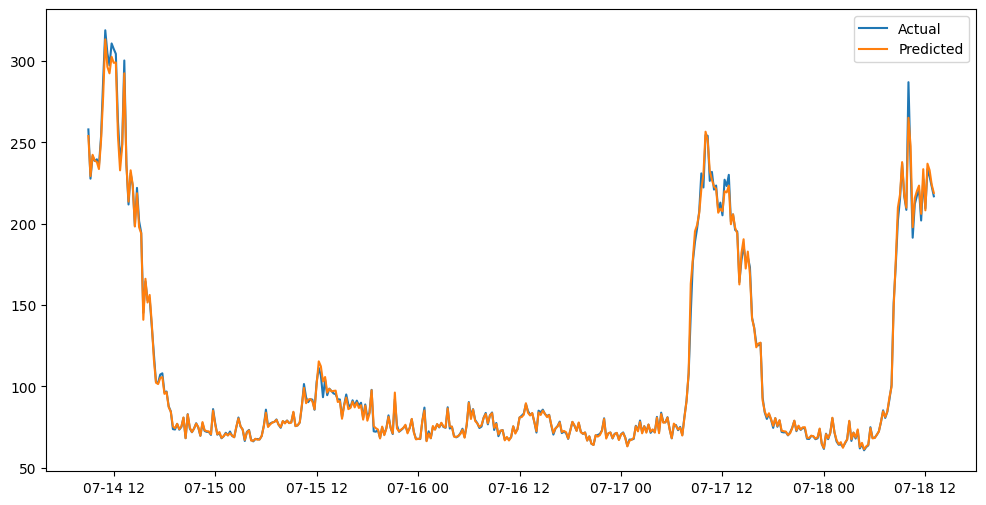

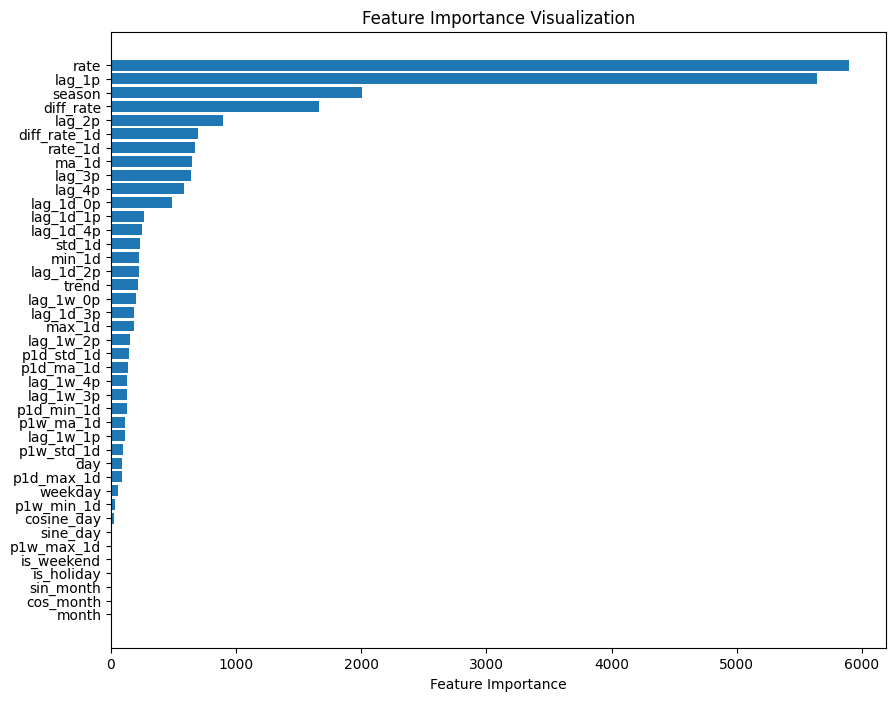

In [3]:
# 학습 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# LightGBM 데이터 세트 생성
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 모델 하이퍼파라미터 설정
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 30,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# 모델 학습
model_a = lgb.train(params,
                    train_data,
                    valid_sets=[valid_data],
                    num_boost_round=1000,
                    valid_names=['validation'],
                    callbacks=[lgb.early_stopping(stopping_rounds=50)])

# 예측 수행
y_pred_a = model_a.predict(X_test, num_iteration=model_a.best_iteration)

# RMSE 출력
rmse_a = root_mean_squared_error(y_test, y_pred_a)
print(f'Experiment A - RMSE: {rmse_a}')

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_a, label='Predicted')
plt.legend()
plt.show()

# Feature Importance Visualization
# 모델의 특성 중요도 추출
feature_importances = model_a.feature_importance()
feature_names = X.columns

# 특성 중요도를 데이터프레임으로 정리
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# 특성 중요도 시각화
plt.figure(figsize=(10, 8))  # 그래프 크기 설정
plt.barh(importance_df['feature'], importance_df['importance'])  # 수평 막대그래프 생성
plt.xlabel('Feature Importance')  # x축 레이블 설정
plt.title('Feature Importance Visualization')  # 그래프 제목 설정
plt.gca().invert_yaxis()  # 중요도가 높은 순으로 표시
plt.show()  # 그래프 출력

### Step C. Features Reduction

28
sorted_features_reduced= [('rate', 5898), ('lag_1p', 5642), ('season', 2004), ('diff_rate', 1664), ('lag_2p', 892), ('diff_rate_1d', 694), ('rate_1d', 668), ('ma_1d', 649), ('lag_1d_0p', 489), ('lag_1d_1p', 267), ('lag_1d_4p', 246), ('min_1d', 225), ('lag_1w_0p', 200), ('max_1d', 181), ('lag_1w_2p', 154), ('p1d_std_1d', 145), ('p1d_ma_1d', 137), ('lag_1w_3p', 130), ('p1d_min_1d', 128), ('lag_1w_1p', 109), ('day', 91), ('weekday', 56), ('cosine_day', 27), ('sine_day', 10), ('is_weekend', 1), ('month', 0), ('sin_month', 0), ('cos_month', 0)]
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[780]	validation's rmse: 2.55219
Experiment A: rmse_a= 2.623 with 41 features
Experiment B: rmse_b= 2.552 with 28 features


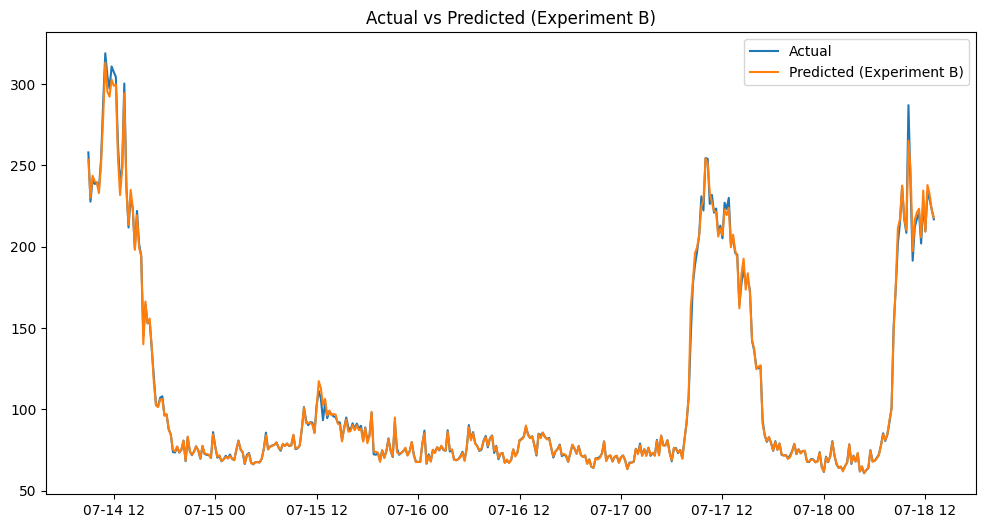

In [4]:
# Experiment B. Feature Reduction을 적용 후
# 특성 감소: Recursive Feature Elimination (RFE) 적용
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=int(X.shape[1] * 0.7), step=1)  # RFE 상위 80%의 특성 선택
X_reduced = selector.fit_transform(X, y)
selected_features_reduced = feature_names[selector.support_]
sorted_features_reduced = sorted(zip(selected_features_reduced, feature_importances[selector.support_]), key=lambda x: x[1], reverse=True)
print(f"{len(sorted_features_reduced)}")
print(f"{sorted_features_reduced= }")

# 학습 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42, shuffle=False)

# LightGBM 데이터 세트 생성
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 모델 하이퍼파라미터 설정
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 30,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# 모델 학습
model_b = lgb.train(params,
                    train_data,
                    valid_sets=[valid_data],
                    num_boost_round=1000,
                    valid_names=['validation'],
                    callbacks=[lgb.early_stopping(stopping_rounds=50)])

# 예측 수행
y_pred_b = model_b.predict(X_test, num_iteration=model_b.best_iteration)

# RMSE 출력
rmse_b = root_mean_squared_error(y_test, y_pred_b)
print(f'Experiment A: {rmse_a= :.3f} with {X.shape[1]} features')
print(f'Experiment B: {rmse_b= :.3f} with {X_reduced.shape[1]} features')

# 예측 결과 시각화 (Experiment B)
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_b, label='Predicted (Experiment B)')
plt.legend()
plt.title('Actual vs Predicted (Experiment B)')
plt.show()

### Step D. Hyperparameter Optimization

In [11]:
import os, yaml, optuna

# 학습 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42, shuffle=False)

# LightGBM 데이터 세트 생성
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)


# YAML 파일 경로 설정
YAML_FILE_PATH = r"/home/ymatics/CodingSpace/2024_AI_BEMS/optuna_study.yaml"

# Optuna 스터디를 생성하거나 기존 파일에서 불러오기
def load_optuna_study(yaml_file_path=YAML_FILE_PATH):
    if os.path.exists(yaml_file_path):
        with open(yaml_file_path, "r") as f:
            trial_data = yaml.safe_load(f)
        study = optuna.create_study(direction='minimize')
        for trial in trial_data:
            study.add_trial(optuna.trial.FrozenTrial(**trial))
    else:
        study = optuna.create_study(direction='minimize')
    return study

# Optuna 스터디를 YAML 파일로 저장
def save_optuna_study(study, yaml_file_path=YAML_FILE_PATH):
    trials_df = study.trials_dataframe()
    trial_data = trials_df.to_dict(orient='records')  # DataFrame을 dict의 리스트로 변환
    with open(yaml_file_path, "w") as f:
        yaml.dump(trial_data, f)

# 모델 하이퍼파라미터 설정 및 optuna를 이용한 튜닝
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'verbose': -1
    }
    
    # 모델 학습
    model = lgb.train(params,
                      train_data,
                      valid_sets=[valid_data],
                      num_boost_round=1000,
                      valid_names=['validation'],
                      callbacks=[lgb.early_stopping(stopping_rounds=50)])
    
    # 예측 수행
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    
    # RMSE 계산
    rmse = root_mean_squared_error(y_test, y_pred)
    return rmse

# 최적화 수행
study = load_optuna_study()
study.optimize(objective, n_trials=10)
print('Best hyperparameters: ', study.best_params)
save_optuna_study(study)

# 최적 하이퍼파라미터로 모델 재학습
best_params = study.best_params
best_params['objective'] = 'regression'
best_params['metric'] = 'rmse'
best_params['boosting_type'] = 'gbdt'

model_opt = lgb.train(best_params,
                    train_data,
                    valid_sets=[valid_data],
                    num_boost_round=1000,
                    valid_names=['validation'],
                    callbacks=[lgb.early_stopping(stopping_rounds=50)])

# 예측 수행
y_pred_opt = model_opt.predict(X_test, num_iteration=model_opt.best_iteration)

# RMSE 출력
rmse_opt = root_mean_squared_error(y_test, y_pred_opt)

print('*'*30) 
print(f'Experiment(Optimization): {rmse_opt= :.3f} with {X_reduced.shape[1]} features')
print(f'{model_opt.params= }')

[I 2024-10-20 13:26:50,896] A new study created in memory with name: no-name-e6e5bd67-dfaf-4c01-a364-46dcf4117dc7


Training until validation scores don't improve for 50 rounds


[I 2024-10-20 13:26:51,291] Trial 0 finished with value: 2.8981596734087605 and parameters: {'learning_rate': 0.024692899161708616, 'num_leaves': 46, 'feature_fraction': 0.7345639411248734, 'bagging_fraction': 0.955363807889498, 'bagging_freq': 10}. Best is trial 0 with value: 2.8981596734087605.


Early stopping, best iteration is:
[460]	validation's rmse: 2.89816
Training until validation scores don't improve for 50 rounds


[I 2024-10-20 13:29:31,860] Trial 1 finished with value: 3.2588107463844134 and parameters: {'learning_rate': 0.10875054415813358, 'num_leaves': 48, 'feature_fraction': 0.8286330215848223, 'bagging_fraction': 0.8952549920919977, 'bagging_freq': 7}. Best is trial 0 with value: 2.8981596734087605.
[I 2024-10-20 13:29:31,970] Trial 2 finished with value: 3.795641541203923 and parameters: {'learning_rate': 0.13922361007939338, 'num_leaves': 50, 'feature_fraction': 0.6590093939232586, 'bagging_fraction': 0.7343933677899736, 'bagging_freq': 4}. Best is trial 0 with value: 2.8981596734087605.


Early stopping, best iteration is:
[100]	validation's rmse: 3.25881
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[114]	validation's rmse: 3.79564
Training until validation scores don't improve for 50 rounds


[I 2024-10-20 13:37:16,878] Trial 3 finished with value: 3.050562265111825 and parameters: {'learning_rate': 0.051220430398826934, 'num_leaves': 68, 'feature_fraction': 0.6731759960720778, 'bagging_fraction': 0.9636460602862941, 'bagging_freq': 2}. Best is trial 0 with value: 2.8981596734087605.


Early stopping, best iteration is:
[229]	validation's rmse: 3.05056
Training until validation scores don't improve for 50 rounds


[I 2024-10-20 13:40:41,925] Trial 4 finished with value: 2.8267378988025444 and parameters: {'learning_rate': 0.07081391058260415, 'num_leaves': 48, 'feature_fraction': 0.8747708547908406, 'bagging_fraction': 0.8593598705255419, 'bagging_freq': 5}. Best is trial 4 with value: 2.8267378988025444.


Early stopping, best iteration is:
[102]	validation's rmse: 2.82674
Training until validation scores don't improve for 50 rounds


[I 2024-10-20 13:43:47,119] Trial 5 finished with value: 3.208830006959265 and parameters: {'learning_rate': 0.11263794885555789, 'num_leaves': 62, 'feature_fraction': 0.8774848997927207, 'bagging_fraction': 0.540645796672127, 'bagging_freq': 6}. Best is trial 4 with value: 2.8267378988025444.


Early stopping, best iteration is:
[144]	validation's rmse: 3.20883
Training until validation scores don't improve for 50 rounds


[I 2024-10-20 13:47:39,412] Trial 6 finished with value: 3.5274924939264953 and parameters: {'learning_rate': 0.1322330848433116, 'num_leaves': 57, 'feature_fraction': 0.7071689920989559, 'bagging_fraction': 0.665616682882521, 'bagging_freq': 4}. Best is trial 4 with value: 2.8267378988025444.


Early stopping, best iteration is:
[145]	validation's rmse: 3.52749
Training until validation scores don't improve for 50 rounds


[I 2024-10-20 14:07:26,436] Trial 7 finished with value: 2.4308393464055844 and parameters: {'learning_rate': 0.016534370729945642, 'num_leaves': 79, 'feature_fraction': 0.6897395800955883, 'bagging_fraction': 0.672799119980635, 'bagging_freq': 10}. Best is trial 7 with value: 2.4308393464055844.


Did not meet early stopping. Best iteration is:
[1000]	validation's rmse: 2.43084
Training until validation scores don't improve for 50 rounds


[I 2024-10-20 14:07:26,941] Trial 8 finished with value: 2.7569237507211373 and parameters: {'learning_rate': 0.01573693949220616, 'num_leaves': 42, 'feature_fraction': 0.9622008527939279, 'bagging_fraction': 0.7551732842664851, 'bagging_freq': 5}. Best is trial 7 with value: 2.4308393464055844.


Early stopping, best iteration is:
[631]	validation's rmse: 2.75692
Training until validation scores don't improve for 50 rounds


[I 2024-10-20 14:15:25,821] Trial 9 finished with value: 3.2112569335098207 and parameters: {'learning_rate': 0.0430711366956001, 'num_leaves': 100, 'feature_fraction': 0.9385310016593318, 'bagging_fraction': 0.9902356159521324, 'bagging_freq': 7}. Best is trial 7 with value: 2.4308393464055844.


Early stopping, best iteration is:
[226]	validation's rmse: 3.21126
Best hyperparameters:  {'learning_rate': 0.016534370729945642, 'num_leaves': 79, 'feature_fraction': 0.6897395800955883, 'bagging_fraction': 0.672799119980635, 'bagging_freq': 10}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4558
[LightGBM] [Info] Number of data points in the train set: 1601, number of used features: 28
[LightGBM] [Info] Start training from score 113.406796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

In [7]:
# 선택된 parameters 출력



Selected parameters:  {'learning_rate': 0.029056709711880704, 'num_leaves': 51, 'feature_fraction': 0.9113365066101219, 'bagging_fraction': 0.8588291467826119, 'bagging_freq': 2, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'num_iterations': 1000}


### Coding Test